In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import yaml
import os, os.path, sys, logging
from functools import reduce
import re, random, scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Get Dataset

In [2]:
# Get the training/test set information
def get_all_labels(input_yaml, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    images = yaml.load(open(input_yaml, 'rb').read())

    for i in range(len(images)):
        images[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), images[i]['path']))
        if riib:
            images[i]['path'] = images[i]['path'].replace('.png', '.pgm')
            images[i]['path'] = images[i]['path'].replace('rgb/train', 'riib/train')
            images[i]['path'] = images[i]['path'].replace('rgb/test', 'riib/test')
            for box in images[i]['boxes']:
                box['y_max'] = box['y_max'] + 8
                box['y_min'] = box['y_min'] + 8
    return images

In [3]:
## BOSCH DATASET
# train_yaml = "images/train.yaml"
# test_yaml = "images/test.yaml"

## SIMULATOR DATASET
simulator_yaml = "simulator/simulator_final.yaml"
dataset = get_all_labels(simulator_yaml)

# Split into paths and labels
paths = []
labels = []
for data in dataset:
    paths.append(data['path'])
    
    # Determine label
    if len(data['boxes']) == 0:
        labels.append('NoLight')
    else:
        labels.append(data['boxes'][0]['label'])

## Create Train, Validation, and Test Sets

In [4]:
# Train, validation, and test sets
# Split ratio is 7:3:1
x_train, x_not_train, y_train, y_not_train = train_test_split(paths, labels, test_size=0.3)
x_validation, x_test, y_validation, y_test = train_test_split(x_not_train, y_not_train, test_size=0.33)

print("Train size: {}, Validation size: {}, Test size: {}".format( \
    len(x_train), len(x_validation), len(x_test))) 
print("All labels in training set:", set(y_train))
print("All labels in validation set:", set(y_validation))
print("All labels in test set:", set(y_test))

Train size: 690, Validation size: 198, Test size: 98
All labels in training set: {'Yellow', 'NoLight', 'Green', 'Red'}
All labels in validation set: {'Yellow', 'NoLight', 'Green', 'Red'}
All labels in test set: {'Red', 'Green', 'NoLight', 'Yellow'}


In [5]:
# Label counts in training set - Needed for oversampling
label_counts = {}
label_indicies = {}
for i, label in enumerate(y_train):
    if label not in label_counts:
        label_counts[label] = 0
        label_indicies[label] = []
    label_counts[label] += 1
    label_indicies[label].append(i)
print(label_counts)
print()
print("Indicies with Yellow label:", label_indicies['Yellow'])

{'Yellow': 60, 'Green': 160, 'NoLight': 263, 'Red': 207}

Indicies with Yellow label: [0, 11, 35, 38, 53, 61, 65, 69, 76, 90, 91, 93, 104, 105, 109, 112, 113, 144, 169, 184, 210, 231, 232, 252, 254, 283, 284, 288, 291, 299, 304, 319, 348, 349, 355, 402, 438, 452, 456, 463, 472, 475, 478, 481, 493, 495, 512, 515, 518, 524, 570, 571, 583, 606, 638, 639, 646, 662, 679, 688]


## Oversample Training Set

In [6]:
# Determine label seen the most
max_count = 0
for label in label_counts:
    max_count = max(max_count, label_counts[label])

# Oversample
oversampled_train_indicies = []
for label in label_indicies:
    random.shuffle(label_indicies[label])
    
    new_label_set = []
    new_label_set += label_indicies[label] * int(max_count / len(label_indicies[label]))
    new_label_set += label_indicies[label][0:max_count % len(label_indicies[label])]
    
    oversampled_train_indicies += new_label_set
    print("Label {} now has {} indicies".format(label, len(new_label_set)))

Label Yellow now has 263 indicies
Label Green now has 263 indicies
Label NoLight now has 263 indicies
Label Red now has 263 indicies


# Create Generator

In [7]:
def loadImage(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# One Hot Encoder Mapping
label_ohe_map = {
    'NoLight': [1, 0, 0, 0],
    'Red': [0, 1, 0, 0],
    'Yellow': [0, 0, 1, 0], 
    'Green': [0, 0, 0, 1]
}

## Create Generator
def createBatchGenerator(indicies, x, y):
    def batchGenerator(batch_size):
        random.shuffle(indicies)
        
        for batch_i in range(0, len(indicies), batch_size):
            images = []
            labels = []
            
            for index in indicies[batch_i:batch_i + batch_size]:
                image = np.array(loadImage(x[index]))
                image = image / 128 - 1.0 # normalize the image
                label = label_ohe_map[y[index]]
                
                images.append(image)
                labels.append(label)
            
            yield np.array(images), np.array(labels)
        
    return batchGenerator

In [8]:
trainingBatchGenerator = createBatchGenerator(oversampled_train_indicies, x_train, y_train)
validationBatchGenerator = createBatchGenerator(list(range(len(x_validation))), x_validation, y_validation)
testBatchGenerator = createBatchGenerator(list(range(len(x_test))), x_test, y_test)

## Create Network

In [9]:
def addConv(input, filters, kernel, stride, padding, keepprob):
    conv = tf.layers.conv2d(input, filters, kernel, stride, padding=padding, \
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), \
                            activation=tf.nn.relu)
    batch_norm = tf.layers.batch_normalization(conv)
    dropout = tf.layers.dropout(batch_norm, keepprob)
    
    return dropout

In [10]:
# Input Placeholders
images = tf.placeholder(tf.float32, (None, None, None, 3), name='input_images')
images_resized = tf.image.resize_images(images, (600, 800))
labels = tf.placeholder(tf.float32, (None, 4), name='labels')
keepprob = tf.placeholder(tf.float32, name='keep_probability')
learningrate = tf.placeholder(tf.float32, name='learning_rate')

In [11]:
# Create Network (Custom, Ensemble CNN)

def createEnsembleCNNUnit(input):
    conv1 = addConv(input, 32, 3, 2, 'valid', keepprob)
    max1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='valid')

    conv2 = addConv(max1, 64, 3, 2, 'valid', keepprob)
    max2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')

    conv3 = addConv(max2, 128, 3, 2, 'valid', keepprob)
    max3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='valid')

    conv4 = addConv(max3, 128, 3, 2, 'valid', keepprob)
    max4 = tf.layers.max_pooling2d(conv4, 2, 2, padding='valid')

    flat = tf.layers.flatten(max4)
    fc1 = tf.layers.dense(flat, 128, activation=tf.nn.relu)
    fc2 = tf.layers.dense(fc1, 64, activation=tf.nn.relu)
    logits = tf.layers.dense(fc2, 4, activation=tf.nn.relu)
    
    return logits

unit_1 = createEnsembleCNNUnit(images_resized)
unit_2 = createEnsembleCNNUnit(images_resized)
unit_3 = createEnsembleCNNUnit(images_resized)

logits = tf.add(tf.add(unit_1, unit_2), unit_3, name="logits")
output = tf.nn.softmax(logits, name="output")

In [12]:
# Create Optimizer
softmax_losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
loss = tf.reduce_mean(softmax_losses)
optimizer = tf.train.AdamOptimizer(learningrate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(labels, 1), tf.argmax(output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train Network

In [13]:
# Hyperparameters
epochs = 100
batch_size = 32
lr = 1e-5
kp = 0.7

In [14]:
# Train Network
sess = tf.Session()

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

print("Training...")
for e in range(epochs):

    # Train Network
    total_loss = 0
    total_accuracy = 0
    i = 0
    for train_images, train_labels in trainingBatchGenerator(batch_size):
        _, loss_val, acc = sess.run([optimizer, loss, accuracy], {images: train_images, labels: train_labels, \
                                               keepprob: kp, learningrate: lr})
        total_loss += loss_val
        total_accuracy += acc * train_images.shape[0]

        # Print iteration information
        i += 1
        if i % 5 == 0:
            print("   Iteration Loss: {:.5f}, Iteration Accuracy: {:.2f}%".format(loss_val, acc * 100))

    # Determine Validation Accuracy
    validation_loss = 0
    validation_acc = 0
    for valid_images, valid_labels in validationBatchGenerator(batch_size):
        loss_val, acc = sess.run([loss, accuracy], {images: valid_images, labels: valid_labels, keepprob: 1.0})
        validation_loss += loss_val
        validation_acc += acc * valid_images.shape[0]

    print("Epoch {}, Training Loss: {:.5f}, Training Accuracy: {:.2f}%, Validation Loss: {:.5f}, Validation Accuracy: {:.2f}%"\
          .format(e+1, total_loss, total_accuracy * 100 / len(oversampled_train_indicies), \
                 validation_loss, validation_acc * 100 / len(x_validation)))


Training...
   Iteration Loss: 1.38634, Iteration Accuracy: 18.75%
   Iteration Loss: 1.38629, Iteration Accuracy: 18.75%
   Iteration Loss: 1.38628, Iteration Accuracy: 28.12%
   Iteration Loss: 1.38628, Iteration Accuracy: 34.38%
   Iteration Loss: 1.38626, Iteration Accuracy: 25.00%
   Iteration Loss: 1.38622, Iteration Accuracy: 34.38%
Epoch 1, Training Loss: 45.74762, Training Accuracy: 24.90%, Validation Loss: 9.70357, Validation Accuracy: 28.79%
   Iteration Loss: 1.38619, Iteration Accuracy: 28.12%
   Iteration Loss: 1.38623, Iteration Accuracy: 34.38%
   Iteration Loss: 1.38629, Iteration Accuracy: 31.25%
   Iteration Loss: 1.38624, Iteration Accuracy: 40.62%
   Iteration Loss: 1.38619, Iteration Accuracy: 34.38%
   Iteration Loss: 1.38631, Iteration Accuracy: 21.88%
Epoch 2, Training Loss: 45.74668, Training Accuracy: 27.00%, Validation Loss: 9.70304, Validation Accuracy: 28.79%
   Iteration Loss: 1.38607, Iteration Accuracy: 34.38%
   Iteration Loss: 1.38618, Iteration Accur

   Iteration Loss: 1.16366, Iteration Accuracy: 56.25%
   Iteration Loss: 1.20118, Iteration Accuracy: 50.00%
   Iteration Loss: 1.11388, Iteration Accuracy: 56.25%
Epoch 19, Training Loss: 40.06292, Training Accuracy: 51.24%, Validation Loss: 9.11536, Validation Accuracy: 39.39%
   Iteration Loss: 1.15918, Iteration Accuracy: 50.00%
   Iteration Loss: 1.15789, Iteration Accuracy: 50.00%
   Iteration Loss: 1.14380, Iteration Accuracy: 59.38%
   Iteration Loss: 1.22120, Iteration Accuracy: 40.62%
   Iteration Loss: 1.21486, Iteration Accuracy: 53.12%
   Iteration Loss: 1.09574, Iteration Accuracy: 56.25%
Epoch 20, Training Loss: 39.06470, Training Accuracy: 52.19%, Validation Loss: 8.95154, Validation Accuracy: 37.88%
   Iteration Loss: 1.06662, Iteration Accuracy: 56.25%
   Iteration Loss: 1.05063, Iteration Accuracy: 62.50%
   Iteration Loss: 1.04674, Iteration Accuracy: 71.88%
   Iteration Loss: 1.15785, Iteration Accuracy: 53.12%
   Iteration Loss: 1.21531, Iteration Accuracy: 50.00

Epoch 37, Training Loss: 19.10543, Training Accuracy: 83.94%, Validation Loss: 5.24858, Validation Accuracy: 76.77%
   Iteration Loss: 0.48789, Iteration Accuracy: 84.38%
   Iteration Loss: 0.53983, Iteration Accuracy: 84.38%
   Iteration Loss: 0.27472, Iteration Accuracy: 93.75%
   Iteration Loss: 0.60550, Iteration Accuracy: 84.38%
   Iteration Loss: 0.50657, Iteration Accuracy: 84.38%
   Iteration Loss: 0.46831, Iteration Accuracy: 90.62%
Epoch 38, Training Loss: 18.13936, Training Accuracy: 84.32%, Validation Loss: 4.96221, Validation Accuracy: 75.76%
   Iteration Loss: 0.34844, Iteration Accuracy: 90.62%
   Iteration Loss: 0.36646, Iteration Accuracy: 93.75%
   Iteration Loss: 0.50993, Iteration Accuracy: 87.50%
   Iteration Loss: 0.57137, Iteration Accuracy: 84.38%
   Iteration Loss: 0.59667, Iteration Accuracy: 81.25%
   Iteration Loss: 0.58780, Iteration Accuracy: 78.12%
Epoch 39, Training Loss: 17.43712, Training Accuracy: 84.89%, Validation Loss: 5.01401, Validation Accuracy:

   Iteration Loss: 0.22573, Iteration Accuracy: 96.88%
   Iteration Loss: 0.30815, Iteration Accuracy: 93.75%
   Iteration Loss: 0.27749, Iteration Accuracy: 90.62%
   Iteration Loss: 0.49991, Iteration Accuracy: 81.25%
   Iteration Loss: 0.36161, Iteration Accuracy: 93.75%
Epoch 56, Training Loss: 11.03541, Training Accuracy: 89.64%, Validation Loss: 5.02401, Validation Accuracy: 77.78%
   Iteration Loss: 0.30701, Iteration Accuracy: 90.62%
   Iteration Loss: 0.39719, Iteration Accuracy: 87.50%
   Iteration Loss: 0.37193, Iteration Accuracy: 87.50%
   Iteration Loss: 0.38466, Iteration Accuracy: 87.50%
   Iteration Loss: 0.29370, Iteration Accuracy: 90.62%
   Iteration Loss: 0.34832, Iteration Accuracy: 87.50%
Epoch 57, Training Loss: 10.59531, Training Accuracy: 89.45%, Validation Loss: 4.97599, Validation Accuracy: 76.77%
   Iteration Loss: 0.28082, Iteration Accuracy: 93.75%
   Iteration Loss: 0.38853, Iteration Accuracy: 87.50%
   Iteration Loss: 0.31099, Iteration Accuracy: 87.50

   Iteration Loss: 0.28515, Iteration Accuracy: 81.25%
Epoch 74, Training Loss: 8.18436, Training Accuracy: 90.78%, Validation Loss: 4.81575, Validation Accuracy: 77.78%
   Iteration Loss: 0.19675, Iteration Accuracy: 93.75%
   Iteration Loss: 0.09389, Iteration Accuracy: 96.88%
   Iteration Loss: 0.50230, Iteration Accuracy: 78.12%
   Iteration Loss: 0.28280, Iteration Accuracy: 90.62%
   Iteration Loss: 0.25205, Iteration Accuracy: 93.75%
   Iteration Loss: 0.14785, Iteration Accuracy: 96.88%
Epoch 75, Training Loss: 7.68963, Training Accuracy: 92.68%, Validation Loss: 4.87105, Validation Accuracy: 78.79%
   Iteration Loss: 0.19447, Iteration Accuracy: 93.75%
   Iteration Loss: 0.24827, Iteration Accuracy: 93.75%
   Iteration Loss: 0.08170, Iteration Accuracy: 100.00%
   Iteration Loss: 0.28955, Iteration Accuracy: 90.62%
   Iteration Loss: 0.33001, Iteration Accuracy: 81.25%
   Iteration Loss: 0.30575, Iteration Accuracy: 90.62%
Epoch 76, Training Loss: 7.56176, Training Accuracy: 9

   Iteration Loss: 0.19419, Iteration Accuracy: 93.75%
   Iteration Loss: 0.17055, Iteration Accuracy: 90.62%
   Iteration Loss: 0.13505, Iteration Accuracy: 93.75%
   Iteration Loss: 0.15977, Iteration Accuracy: 96.88%
   Iteration Loss: 0.24295, Iteration Accuracy: 87.50%
   Iteration Loss: 0.08425, Iteration Accuracy: 96.88%
Epoch 93, Training Loss: 6.12038, Training Accuracy: 94.20%, Validation Loss: 6.11460, Validation Accuracy: 77.27%
   Iteration Loss: 0.09744, Iteration Accuracy: 96.88%
   Iteration Loss: 0.09707, Iteration Accuracy: 100.00%
   Iteration Loss: 0.40258, Iteration Accuracy: 90.62%
   Iteration Loss: 0.12055, Iteration Accuracy: 96.88%
   Iteration Loss: 0.18276, Iteration Accuracy: 90.62%
   Iteration Loss: 0.22301, Iteration Accuracy: 96.88%
Epoch 94, Training Loss: 6.06964, Training Accuracy: 94.39%, Validation Loss: 5.13646, Validation Accuracy: 78.79%
   Iteration Loss: 0.12620, Iteration Accuracy: 96.88%
   Iteration Loss: 0.16085, Iteration Accuracy: 96.88%

In [15]:
# Save Network
saver = tf.train.Saver()
saver.save(sess, './models/cnn_ensemble.ckpt')

'./models/cnn_ensemble.ckpt'

## Test Network

In [16]:
saver = tf.train.Saver()
saver.restore(sess, './models/cnn_ensemble.ckpt')

batch_size = 32

INFO:tensorflow:Restoring parameters from ./models/cnn_ensemble.ckpt


In [17]:
# Test Accuracy
total_loss = 0
total_acc = 0

for test_images, test_labels in testBatchGenerator(batch_size):
    loss_val, acc = sess.run([loss, accuracy], {images: test_images, labels: test_labels, keepprob: 1.0})
    total_loss += loss_val
    total_acc += acc * test_images.shape[0]

print("Test Loss: {:.5f}, Accuracy: {:.2f}%".format(total_loss, total_acc * 100 / len(x_test)))


Test Loss: 2.30187, Accuracy: 83.67%


## Visually Confirm Working Network

In [18]:
label_ohe_map_reversed = ['NoLight', 'Red', 'Yellow', 'Green']

In [19]:
len(x_test)

98

Network guessed: NoLight
Actual label: Red
INCORRECT


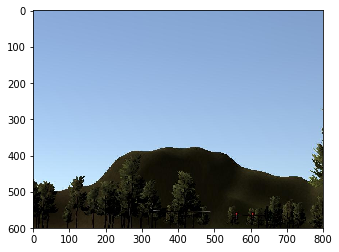

In [20]:
desired_test_index = 0

# Load Image
test_img = loadImage(x_test[desired_test_index])
plt.imshow(test_img)

# Run Classification
ohe_index = sess.run(tf.argmax(output, 1), {images: [test_img], keepprob: 1.0})[0]

# Print Information
print("Network guessed: {}".format(label_ohe_map_reversed[ohe_index]))
print("Actual label: {}".format(y_test[desired_test_index]))
if label_ohe_map_reversed[ohe_index] == y_test[desired_test_index]:
    print("Correct!")
else:
    print("INCORRECT")

## Freeze the Graph into a Protobuf File

In [21]:
from tensorflow.python.tools.freeze_graph import freeze_graph

In [22]:
for name in [op.name for op in tf.get_default_graph().get_operations()]:
    for nodeName in ["output", "input_image", "keep_probability"]:
        if nodeName in name:
            print(name)

input_images
keep_probability
output
